In [67]:
import pandas as pd, numpy as np
import torch, timm
from  torchvision.transforms import InterpolationMode
from torchvision.transforms import v2
import torchvision.datasets as datasets
import tensorflow as tf, tensorflow_datasets as tfds
from tqdm import tqdm
import matplotlib.pyplot as plt


## Exploring checkpoints

In [2]:
df = pd.read_csv('data/index.csv')

# all columns of index.csv dataframe
index_cols = list(df.columns)

# list of all models in the vit family
model_types = df.name.unique()

# best checkpoint filenames based on pre-train results
best_pretrains = set(
    df.query('ds=="i21k"')
    .groupby('name')
    .apply(lambda df: df.sort_values('final_val').iloc[-1], include_groups=False)
    .filename
)
# Select all finetunes from these models.
best_finetunes = df.loc[df.filename.apply(lambda filename: filename in best_pretrains)]

# all adapted datasets
adapt_datasets = best_finetunes.adapt_ds.unique()

In [3]:
print('Datasets   : ', adapt_datasets)
print('Model types: ', model_types)
print('Index cols : ', index_cols)

Datasets   :  ['imagenet2012' 'cifar100' 'resisc45' 'oxford_iiit_pet' 'kitti']
Model types:  ['Ti/16' 'S/32' 'B/16' 'L/16' 'R50+L/32' 'R26+S/32' 'S/16' 'B/32'
 'R+Ti/16' 'B/8']
Index cols :  ['name', 'ds', 'epochs', 'lr', 'aug', 'wd', 'do', 'sd', 'best_val', 'final_val', 'final_test', 'adapt_ds', 'adapt_lr', 'adapt_steps', 'adapt_resolution', 'adapt_final_val', 'adapt_final_test', 'params', 'infer_samples_per_sec', 'filename', 'adapt_filename']


In [83]:
# helper functions
def cmp_models(datasets, models_list):
    print('Models: ', models_list, '\n')
    
    for ds in datasets:
        info = [
            best_finetunes.query(f'name=="{m}" and adapt_ds=="{ds}"')
            .sort_values('adapt_final_val') # I'm not sure whether we should sort by validation result or test result
            .iloc[-1] for m in models_list  # but original colab uses validation result
        ]
    
        print('Adapt dataset: ', ds)
        print(f'Resolutions: {[int(i.adapt_resolution) for i in info]}')
        print(f'Final vals: {[round(float(i.adapt_final_val), 3) for i in info]}')
        print(f'Final tests: {[round(float(i.adapt_final_test), 3) for i in info]}\n')

def get_best_model(adapt_ds, model_type):
    out = (
        best_finetunes.query(f'name=="{model_type}" and adapt_ds=="{adapt_ds}"')
        .sort_values('adapt_final_val').iloc[-1].adapt_filename
    )
    return out

In [5]:
cmp_models(adapt_datasets, ['B/16', 'S/16', 'Ti/16'])

Models:  ['B/16', 'S/16', 'Ti/16'] 

Adapt dataset:  imagenet2012
Resolutions: [384, 384, 384]
Final vals: [0.894, 0.871, 0.82]
Final tests: [0.855, 0.837, 0.782]

Adapt dataset:  cifar100
Resolutions: [224, 224, 224]
Final vals: [0.94, 0.922, 0.888]
Final tests: [0.941, 0.921, 0.88]

Adapt dataset:  resisc45
Resolutions: [384, 384, 384]
Final vals: [0.977, 0.972, 0.967]
Final tests: [0.975, 0.966, 0.961]

Adapt dataset:  oxford_iiit_pet
Resolutions: [384, 384, 384]
Final vals: [0.984, 0.967, 0.954]
Final tests: [0.947, 0.934, 0.911]

Adapt dataset:  kitti
Resolutions: [224, 384, 384]
Final vals: [0.865, 0.857, 0.851]
Final tests: [0.813, 0.835, 0.831]



In [82]:
best_finetunes.query(f'name=="Ti/16" and adapt_ds=="cifar100"').sort_values('adapt_final_val')#.iloc[-3].adapt_filename
get_best_model('cifar100', 'Ti/16')

np.int64(224)

## Loading model and dataset

In [86]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
timm_modelnames = {
    'Ti/16-224': 'vit_tiny_patch16_224',
    'Ti/16-384': 'vit_tiny_patch16_384', 
    'S/16-224': 'vit_small_patch16_224', 
    'S/16-384': 'vit_small_patch16_384',
    'B/16-224': 'vit_base_patch16_224', 
    'B/16-384': 'vit_base_patch16_384'
}

def load_model_and_dataset(adapt_ds, model_type, batch_size):
    model_to_load = get_best_model(adapt_ds, model_type)
    # sample output: Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224
    res = int(model_to_load.split('_')[-1])

    # load dataset
    ds_transform = v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((res, res)),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    dataset = datasets.CIFAR100('data/', train=False, transform=ds_transform, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    model = timm.create_model(timm_modelnames[f'{model_type}-{res}'], num_classes=len(dataset.classes))

    # downloading a checkpoint automatically requires credentials, that's why I didn't implement it
    # you should download it manually and place the .npz file in the data folder
    if not tf.io.gfile.exists(f'data/{model_to_load}.npz'):
      tf.io.gfile.copy(f'gs://vit_models/augreg/{model_to_load}.npz', f'data/{model_to_load}.npz')

    timm.models.load_checkpoint(model, f'data/{model_to_load}.npz')

    model.to(device)
    model.eval()

    return model, dataset, dataloader


batch_size = 32
model, dataset, dataloader = load_model_and_dataset('cifar100', 'Ti/16', batch_size)

Files already downloaded and verified


In [87]:
sm = torch.nn.Softmax(dim=1)

with torch.no_grad():
    acc, correct = 0, 0
    for features, labels in tqdm(iter(dataloader)):
        features = features.to(device)
        labels = labels.to(device)
        clf = sm(model(features)).argmax(1)
        correct += (clf == labels).sum()

acc = correct / len(dataset)
acc

100%|█████████████████████████████████████████████████████████| 313/313 [00:47<00:00,  6.54it/s]


tensor(0.8811, device='mps:0')

### Downloading dataset from tensorflow_datasets

In [6]:
filename = get_best_model('cifar100', 'Ti/16')

tfds_name = filename.split('--')[1].split('-')[0]
resolution = int(filename.split('_')[-1])

ds, ds_info = tfds.load(tfds_name, with_info=True)
ds_info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/shams/tensorflow_datasets/cifar100/incomplete.KZ5DOQ_3.0.2/cifar100-train.tfrecord*...:   0%|…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/shams/tensorflow_datasets/cifar100/incomplete.KZ5DOQ_3.0.2/cifar100-test.tfrecord*...:   0%| …

Dataset cifar100 downloaded and prepared to /Users/shams/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/Users/shams/tensorflow_datasets/cifar100/3.0.2',
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    disab

In [13]:
def pp(img, sz):
    """Simple image preprocessing."""
    img = tf.cast(img, float) / 255.0
    img = tf.image.resize(img, [sz, sz])
    return img

def pp_torch(img, sz):
    """Simple image preprocessing for PyTorch."""
    img = pp(img, sz)
    img = img.numpy().transpose([2, 0, 1])  # PyTorch expects NCHW format.
    return torch.tensor(img[None])

In [59]:
sm = torch.nn.Softmax(dim=1)

def pp(img, sz):
    """Simple image preprocessing."""
    img = tf.cast(img, float) / 255.0
    img = tf.image.resize(img, [sz, sz])
    return img

def pp_torch(img, sz):
    """Simple image preprocessing for PyTorch."""
    img = pp(img, sz)
    img = img.numpy().transpose([2, 0, 1])  # PyTorch expects NCHW format.
    return torch.tensor(img[None])

# with torch.no_grad():
#     acc, correct = 0, 0
#     for d in tqdm(iter(ds['test'])):
#         features = (pp_torch(d['image'], 224)).to(device)
#         labels = torch.tensor(d['label'].numpy(), dtype=torch.int64, device=device)
#         clf = sm(model(features)).argmax(1)
#         correct += (clf == labels).sum()

# acc = correct / len(dataset)
# acc

tf.Tensor(43, shape=(), dtype=int64) 29


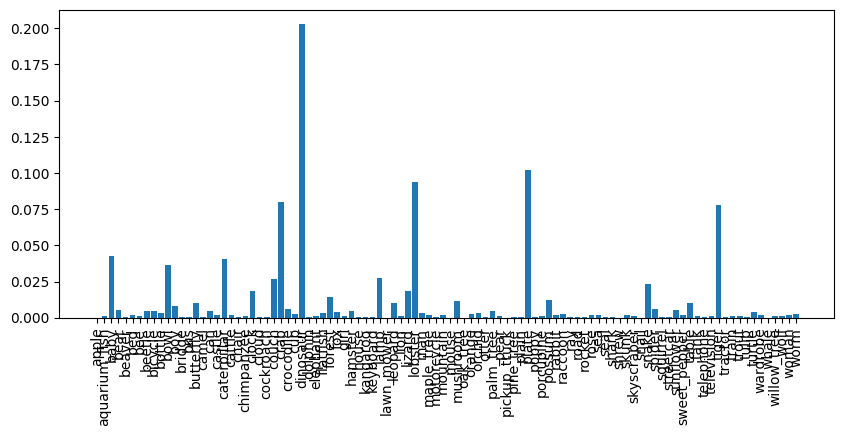

In [73]:
d = next(iter(ds['test']))

with torch.no_grad():
  logits, = sm(model(
      pp_torch(d['image'], resolution).to(device))
      ).detach().cpu().numpy()

plt.figure(figsize=(10, 4))
plt.bar(list(map(ds_info.features['label'].int2str, range(len(logits)))), logits)
plt.xticks(rotation=90);
print(d['label'], logits.argmax())

### Other section